In [6]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
MODELS_INFO = {
    'gpt2-large': {
        'recurring': 'recurring__gsm8k__gpt2-large__output.json',
        'greedy': 'greedy__gsm8k__gpt2-large__output.json',
        'baseline': 'baseline__gsm8k__gpt2-large__output.json',
        'model_size': 774_000_000,
    },
    'gemma-2b': {
        'recurring': 'recurring__gsm8k__gemma-2b__output.json',
        'greedy': 'greedy__gsm8k__gemma-2b__output.json',
        'baseline': 'baseline__gsm8k__gemma-2b__output.json',
        'model_size': 2_510_000_000,
    },
    'gemma-7b': {
        'recurring':'recurring__gsm8k__gemma-7b__output.json',
        'greedy': 'greedy__gsm8k__gemma-7b__output.json',
        'baseline': 'baseline__gsm8k__gemma-7b__output.json',
        'model_size': 8_540_000_000,
    },
}

METHODS = ['recurring', 'greedy', 'baseline']

MAJORITY_THRESHOLDS = [0.3,0.5,0.7,0.9]

RECURRING_TIMESTEPS = 5

In [8]:
def conv_float(x):
    return float(x.replace(',', '')) if len(x) > 0 else float('-inf')

def correct_with_majority_threshold(instance, correct_answer, majority_threshold=0.5):
    answer_distributions = instance['answer_distribution']
    
    termination_index = RECURRING_TIMESTEPS-1
    for ts in range(termination_index):
        if answer_distributions[ts][0][1] >= majority_threshold:
            termination_index = ts
            break
    
    return conv_float(instance["majority_vote_answers"][termination_index]) == correct_answer

def get_accuracy(model_name, method, majority_threshold=1):
    if MODELS_INFO[model_name][method] is None:
        return 0
    file = os.path.join('../../results/', MODELS_INFO[model_name][method])
    output = json.load(open(file))
    
    if method == 'recurring':
        return sum(1 for inst in output if correct_with_majority_threshold(inst, conv_float(inst['ground_truth_answers']), majority_threshold)) / len(output)
    elif method == 'baseline' or method == 'greedy':
        return sum(1 for inst in output if conv_float(inst['majority_vote_answer']) == conv_float(inst['ground_truth_answer'])) / len(output)
    raise ValueError('Invalid method')

In [9]:
plot_df = pd.DataFrame(columns=['model', 'method', 'accuracy', 'model_size'])

for model_name in MODELS_INFO:
    for method in METHODS:
        if method == 'recurring':
            for majority_threshold in MAJORITY_THRESHOLDS:
                print(f'Processing {model_name} - {method} - {majority_threshold}')
                plot_df = pd.concat([plot_df, pd.DataFrame([{
                    'model': model_name, 
                    'method': f'{method} - {majority_threshold}', 
                    'accuracy': get_accuracy(model_name, method, majority_threshold), 
                    'model_size': MODELS_INFO[model_name]['model_size']
                }])], ignore_index=True)
        else:
            print(f'Processing {model_name} - {method}')
            plot_df = pd.concat([plot_df, pd.DataFrame([{
                'model': model_name, 
                'method': method, 
                'accuracy': get_accuracy(model_name, method), 
                'model_size': MODELS_INFO[model_name]['model_size']
            }])], ignore_index=True)

Processing gpt2-large - recurring - 0.3


C:\Users\AADAM\AppData\Local\Temp\ipykernel_51148\1430614560.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, pd.DataFrame([{


Processing gpt2-large - recurring - 0.5
Processing gpt2-large - recurring - 0.7
Processing gpt2-large - recurring - 0.9
Processing gpt2-large - greedy
Processing gpt2-large - baseline
Processing gemma-2b - recurring - 0.3
Processing gemma-2b - recurring - 0.5
Processing gemma-2b - recurring - 0.7
Processing gemma-2b - recurring - 0.9
Processing gemma-2b - greedy
Processing gemma-2b - baseline
Processing gemma-7b - recurring - 0.3
Processing gemma-7b - recurring - 0.5
Processing gemma-7b - recurring - 0.7
Processing gemma-7b - recurring - 0.9
Processing gemma-7b - greedy
Processing gemma-7b - baseline


In [12]:
plot_df

,model,method,accuracy,model_size
0,gpt2-large,recurring - 0.3,0.018653,774000000
1,gpt2-large,recurring - 0.5,0.018767,774000000
2,gpt2-large,recurring - 0.7,0.018540,774000000
3,gpt2-large,recurring - 0.9,0.016833,774000000
4,gpt2-large,greedy,0.013421,774000000
5,gpt2-large,baseline,0.020018,774000000
6,gemma-2b,recurring - 0.3,0.235896,2510000000
7,gemma-2b,recurring - 0.5,0.234190,2510000000
8,gemma-2b,recurring - 0.7,0.224067,2510000000
9,gemma-2b,recurring - 0.9,0.219859,2510000000


[]

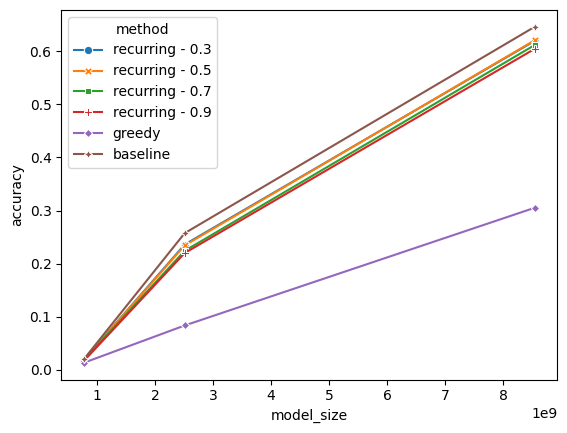

In [13]:
sns.lineplot(data=plot_df, x='model_size', y='accuracy', hue='method', style='method', markers=True, dashes=False)
plt.plot()